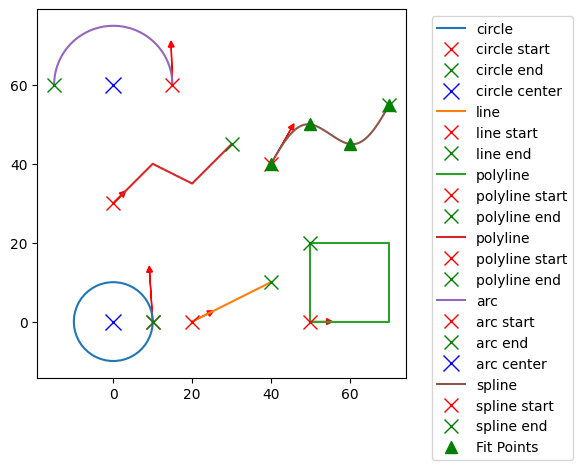

In [1]:
import ezdxf
import numpy as np
import math
import matplotlib.pyplot as plt

def extract_shapes_points(dxf_file, num_points=50):
    doc = ezdxf.readfile(dxf_file)
    msp = doc.modelspace()
    shapes_data = []

    # 圆
    for circle in msp.query("CIRCLE"):
        center = circle.dxf.center
        radius = circle.dxf.radius
        angles = np.linspace(0, 2*math.pi, num_points, endpoint=False)
        points = [(center.x + radius*math.cos(theta),
                   center.y + radius*math.sin(theta)) for theta in angles]
        points.append(points[0])  # 闭合圆
        shapes_data.append({
            "type": "circle",
            "points": points,
            "center": (center.x, center.y),
            "start_point": points[0],
            "end_point": points[-1]
        })

    # 直线
    for line in msp.query("LINE"):
        start, end = line.dxf.start, line.dxf.end
        xs = np.linspace(start.x, end.x, num_points)
        ys = np.linspace(start.y, end.y, num_points)
        points = list(zip(xs, ys))
        shapes_data.append({
            "type": "line",
            "points": points,
            "start_point": (start.x, start.y),
            "end_point": (end.x, end.y)
        })

    # 折线/矩形
    for pl in msp.query("LWPOLYLINE POLYLINE"):
        vertices = list(pl.get_points("xy"))  # 只取XY坐标
        points = []
        for i in range(len(vertices) - (0 if pl.closed else 1)):
            x1, y1 = vertices[i]
            x2, y2 = vertices[(i+1) % len(vertices)]
            xs = np.linspace(x1, x2, num_points)
            ys = np.linspace(y1, y2, num_points)
            points.extend(list(zip(xs, ys)))
        shapes_data.append({
            "type": "polyline",
            "points": points,
            "vertices": vertices,
            "start_point": vertices[0],
            "end_point": vertices[-1]
        })

    # 圆弧
    for arc in msp.query("ARC"):
        center = arc.dxf.center
        radius = arc.dxf.radius
        start_angle = math.radians(arc.dxf.start_angle)
        end_angle = math.radians(arc.dxf.end_angle)
        span = (end_angle - start_angle) % (2 * math.pi)
        angles = start_angle + np.linspace(0, span, num_points)
        points = [(center.x + radius*math.cos(theta),
                center.y + radius*math.sin(theta)) for theta in angles]
        shapes_data.append({
            "type": "arc",
            "points": points,
            "center": (center.x, center.y),
            "start_point": points[0],
            "end_point": points[-1]
        })

    # 样条曲线
    for spline in msp.query("SPLINE"):
        bspline = spline.construction_tool()
        points = [(p.x, p.y) for p in bspline.approximate(num_points)]
        control_points = [(p[0], p[1]) for p in spline.control_points]
        fit_points = [(p[0], p[1]) for p in spline.fit_points]
        shapes_data.append({
            "type": "spline",
            "points": points,
            "control_points": control_points,
            "fit_points": fit_points,
            "start_point": points[0],
            "end_point": points[-1]
        })

    return shapes_data


def visualize_shapes(shapes_data):
    fig, ax = plt.subplots()
    for shape in shapes_data:
        xs, ys = zip(*shape["points"])
        ax.plot(xs, ys, '-', label=shape["type"])

        # 起点标记
        if "start_point" in shape:
            ax.plot(shape["start_point"][0], shape["start_point"][1],
                    'rx', markersize=10, label=f"{shape['type']} start")

        # 终点标记
        if "end_point" in shape:
            ax.plot(shape["end_point"][0], shape["end_point"][1],
                    'gx', markersize=10, label=f"{shape['type']} end")

        # 圆心标记
        if shape["type"] in ["circle", "arc"] and "center" in shape:
            cx, cy = shape["center"]
            ax.plot(cx, cy, 'bx', markersize=12, label=f"{shape['type']} center")

        # 方向箭头（起点到第二个点）
        if len(shape["points"]) > 1:
            start_x, start_y = shape["points"][0]
            next_x, next_y = shape["points"][1]
            dx, dy = next_x - start_x, next_y - start_y
            ax.arrow(start_x, start_y, dx*10, dy*10,
                     head_width=1.5, head_length=1.5, fc='red', ec='red')

        # 控制点和拟合点（样条）
        if shape["type"] == "spline":
            if shape["control_points"]:
                cx, cy = zip(*shape["control_points"])
                ax.plot(cx, cy, 'bs', markersize=8, label="Control Points")
            if shape["fit_points"]:
                fx, fy = zip(*shape["fit_points"])
                ax.plot(fx, fy, 'g^', markersize=8, label="Fit Points")

    ax.set_aspect('equal')

    # 将图例放在图像外部右侧
    ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.tight_layout()  # 自动调整布局，避免遮挡

    plt.show()

# 示例调用
shapes = extract_shapes_points("../../dxf/shapes.dxf", num_points=50)
visualize_shapes(shapes)